In [9]:
import numpy as np
import torch
from tqdm.notebook  import tqdm
import pickle
import copy

from jeffutils.utils import reimport
from models.pytorch_model import OrigamiNetwork
reimport("from models.pytorch_model import OrigamiNetwork", globals())
from vis_helpers import *
reimport("from vis_helpers import *", globals())

### Data

In [10]:
def layer_sam(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    return D + mask[:,np.newaxis] * (2*n - (2 * np.outer(scales, n)))
fv1 = np.array([0,.5])
size = 10
X1, X2 = np.meshgrid(np.linspace(-2,2,size), np.linspace(-2,2,size))
sandwichX = np.concatenate((X1.reshape(-1,1), X2.reshape(-1,1)), axis=1)
sandwichY = layer_sam(sandwichX, fv1)[:,1] > -.5
# plt.scatter(sandwichX[:,0], sandwichX[:,1], c=sandwichY)
sandwichX = torch.tensor(sandwichX, dtype=torch.float32)
sandwichY = torch.tensor(sandwichY, dtype=torch.float32)

size = 100
x1 = np.linspace(-2,2,size)
x2 = np.linspace(-2,2,size)
X1,X2 = np.meshgrid(x1,x2)
xorX = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
xorY = np.array([[1 if (i < size//2 and j < size//2 or i >= size//2 and j >= size//2) else 0 for j in range(size)] for i in range(size)]).reshape(-1)
# plt.scatter(xorX[:,0], xorX[:,1], c=xorY)
xorX = torch.tensor(xorX, dtype=torch.float32)
xorY = torch.tensor(xorY, dtype=torch.float32)

count = 20
onedX = np.linspace(-2,2,count)
onedY = np.zeros(count)
onedY[:6] = 1
onedY[-6:] = 1
onedX = np.expand_dims(onedX, axis=1)
onedX = torch.tensor(onedX, dtype=torch.float32)
onedY = torch.tensor(onedY, dtype=torch.float32)

## Training

In [11]:
test_case_x = sandwichX
test_case_y = sandwichY
print("Testing sandwich problem")
layers = 1
test = OrigamiNetwork(n_layers=layers, width=None, epochs=300, 
                      learning_rate=0.05, optimizer_type="adam", reg=0, leak=0.08)
test.load_data(test_case_x, test_case_y, freeze_folds=True)
test.set_folds([np.array([-0.00466453, 0.53786325])])
test.fit(verbose=0)
logits, out = test.forward(test_case_x, return_intermediate=True)

# print("\nScore =", test.score(), "after training")
print("Cut", test.get_cut_vector(), "Fold vectors", test.get_fold_vectors(), sep="\n")

Testing sandwich problem
Cut
[[ 0.4858909  -9.134387  ]
 [ 0.28045544  9.090652  ]]
Fold vectors
[array([-0.00466453,  0.53786325], dtype=float32)]


In [12]:
# reimport("from vis_helpers import *", globals())
plot_wiggles(test.fold_history, layer=0)

In [13]:
# Visualize folds at each layer
# reimport("from models.pytorch_model_old import OrigamiNetwork", globals())
reimport("from vis_helpers import *", globals())
for layer_index in range(layers):
    plot_folds(test, layer_index=layer_index, use_plotly=True)

Plotting: 100%|██████████| 50/50 [00:00<00:00, 307.70it/s]


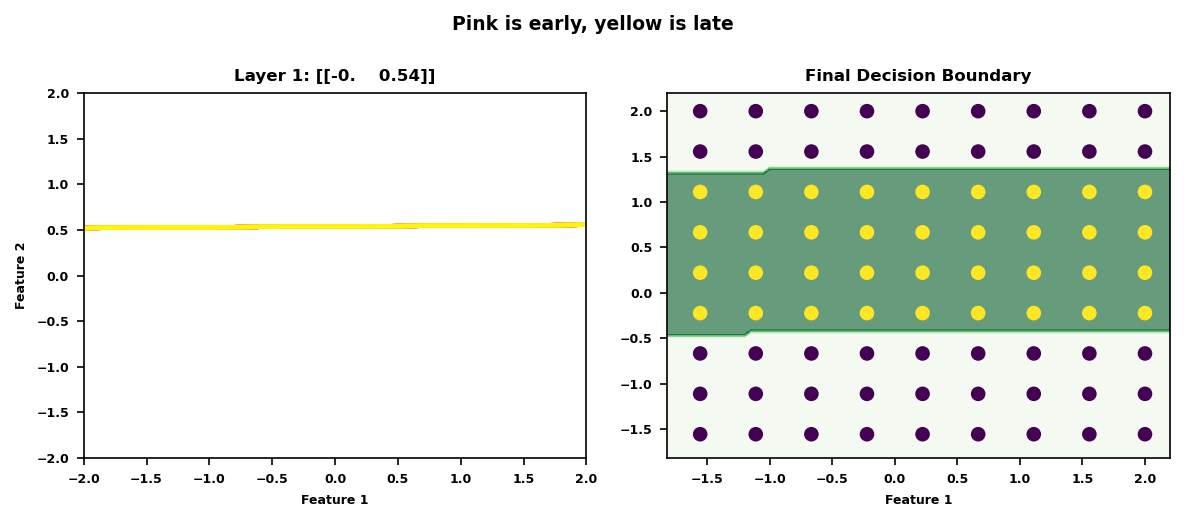

In [14]:
reimport("from vis_helpers import *", globals())
plot_history(test, verbose=2)